In [1]:
import scikit_posthocs as sp
from statds.no_parametrics import friedman, hommel
from critical_diagrams_2d import Diagrams
from generate_new_bns import ProbabilisticModel
import pickle
import networkx as nx
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ["OMP_NUM_THREADS"] = '16'

In [2]:
methodLocDict = {
                '$k$NNCIT': './results/synthetic/knncit/',
                 'MRCIT': './results/synthetic/mrcit/',
                 'HC': './results/synthetic/hillclimbing/',
                 'MMCIT': './results/synthetic/mmcit/',
                 'CGIT': './results/synthetic/cgit/',
                 'DGCIT': './results/synthetic/dgcit/',
                 'LCIT': './results/synthetic/lcit/',
                 }

groundTruthLoc = './hspbns/'

In [3]:
def structural_hamming_distance(ground_truth, learned_graph, method):

    shd_value = 0
    ground_truth = ground_truth.graph().to_pdag()
    if 'HC' in method:
        learned_graph = learned_graph.graph().to_pdag()

    def get_skeleton(graph):
        edges = {tuple(sorted(edge)) for edge in graph.edges()}  # Undirected edges
        arcs = {tuple(sorted(arc)) for arc in graph.arcs()}      # Directed edges (unordered)
        return edges | arcs

    true_skel = get_skeleton(ground_truth)
    learned_skel = get_skeleton(learned_graph)

    # Count skeleton mismatch
    shd_value = len(true_skel.symmetric_difference(learned_skel))

    common_edges = true_skel & learned_skel
    for u, v in common_edges:
    
        if ground_truth.has_arc(u, v) or ground_truth.has_arc(v, u):
            true_dir = (u, v) if ground_truth.has_arc(u, v) else (v, u)
        else:
            true_dir = None

        if learned_graph.has_arc(u, v) or learned_graph.has_arc(v, u):
            learned_dir = (u, v) if learned_graph.has_arc(u, v) else (v, u)
        else:
            learned_dir = None

        # Count orientation mismatch
        if true_dir != learned_dir:
            shd_value += 1

    return shd_value


def f1_score(ground_truth, learned_graph, method):
    G_gt = nx.DiGraph()
    G_gt.add_nodes_from(ground_truth.nodes())
    G_gt.add_edges_from(ground_truth.arcs())
    gt_graph_skel = G_gt.to_undirected().to_directed()
    gt_edges = set((str(u), str(v)) for u, v in gt_graph_skel.edges())
    gt_non_edges = set((str(u), str(v))
                       for u, v in nx.non_edges(gt_graph_skel))

    if 'HC' not in method:
        learned_graph = learned_graph.to_approximate_dag()

    G = nx.DiGraph()
    G.add_nodes_from(learned_graph.nodes())
    G.add_edges_from(learned_graph.arcs())

    learned_graph_skel = G.to_undirected().to_directed()
    learned_edges = set((u, v) for u, v in learned_graph_skel.edges())
    learned_non_edges = set((u, v)
                            for u, v in nx.non_edges(learned_graph_skel))

    true_positives = list(gt_edges & learned_edges)
    tp = len(true_positives) // 2

    false_positives = list(gt_non_edges & learned_edges)
    fp = len(false_positives) // 2

    false_negatives = list(gt_edges & learned_non_edges)
    fn = len(false_negatives) // 2

    f1 = 2 * tp / (fp + fn + 2 * tp)

    return f1

In [4]:
entry = []
for graphFile in sorted(os.listdir(groundTruthLoc)):
    splitted = graphFile.split('_')
    n_rep = splitted[0]
    n_vars = splitted[1]
    discrete_ratio = splitted[2].replace('p', '.')
    kde_ratio = splitted[3].replace('p', '.')

    edge_density = splitted[4][:-4].replace('p', '.')
    ground_truth = ProbabilisticModel.load(
        groundTruthLoc+graphFile).ground_truth_bn

    for samples in ['150', '375', '750', '1500', '3000']:
        for method in methodLocDict.keys():
            try:
                with open(methodLocDict[method] + graphFile[:-4] + '_' + samples + '.pkl', "rb") as f:
                    learned_graph = pickle.load(f)

                f1 = f1_score(ground_truth, learned_graph, method)
                shd = structural_hamming_distance(
                    ground_truth, learned_graph, method)
                
                entry.append([method, n_rep, n_vars, discrete_ratio,
                             kde_ratio, edge_density, samples, f1, shd])
            except Exception as e:
                print("Error in", samples, method, graphFile)
                print(e)

columns = ['method', 'n_rep', 'n_vars', 'discrete_ratio',
           'kde_ratio', 'edge_density', 'samples', 'F1', 'SHD']

df = pd.DataFrame(entry, columns=columns)

Error in 750 LCIT 0_10_0p1_0p0_0p06.pkl
[Errno 2] No such file or directory: './results/synthetic/lcit/0_10_0p1_0p0_0p06_750.pkl'
Error in 750 LCIT 0_10_0p1_0p0_0p18.pkl
[Errno 2] No such file or directory: './results/synthetic/lcit/0_10_0p1_0p0_0p18_750.pkl'
Error in 1500 LCIT 0_10_0p1_0p0_0p18.pkl
[Errno 2] No such file or directory: './results/synthetic/lcit/0_10_0p1_0p0_0p18_1500.pkl'
Error in 3000 LCIT 0_10_0p1_1p0_0p18.pkl
[Errno 2] No such file or directory: './results/synthetic/lcit/0_10_0p1_1p0_0p18_3000.pkl'
Error in 150 LCIT 0_10_0p5_0p0_0p14.pkl
[Errno 2] No such file or directory: './results/synthetic/lcit/0_10_0p5_0p0_0p14_150.pkl'
Error in 750 LCIT 0_20_0p1_0p0_0p14.pkl
[Errno 2] No such file or directory: './results/synthetic/lcit/0_20_0p1_0p0_0p14_750.pkl'
Error in 3000 LCIT 0_20_0p1_0p0_0p14.pkl
[Errno 2] No such file or directory: './results/synthetic/lcit/0_20_0p1_0p0_0p14_3000.pkl'
Error in 750 LCIT 0_20_0p1_0p0_0p18.pkl
[Errno 2] No such file or directory: './resu

### Plots for F1

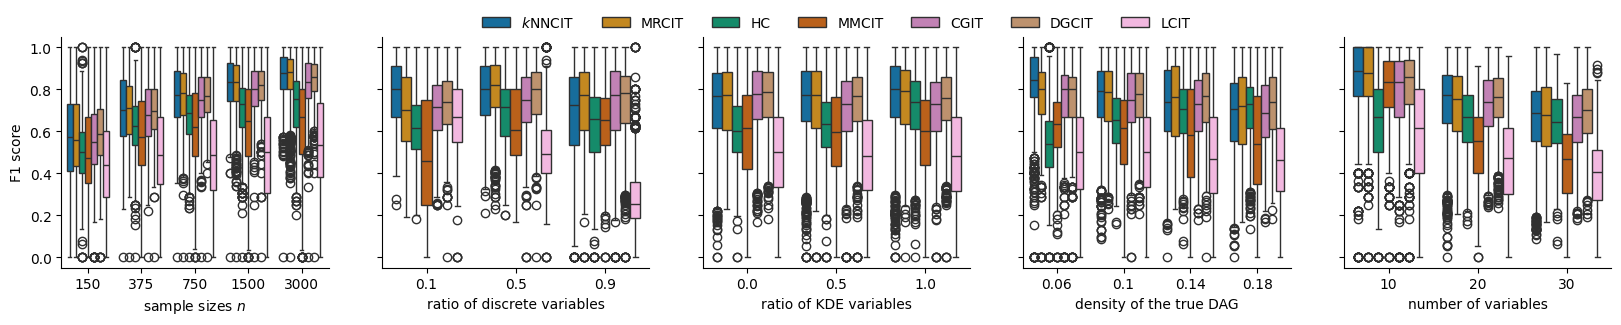

In [15]:
hue_order = methodLocDict.keys()

fig, axs = plt.subplots(ncols=5, sharey=True, figsize=(20, 3.0))
palette = 'colorblind'
f1 = sns.boxplot(x="samples", y="F1", hue="method", palette=palette, hue_order=hue_order,
                 data=df.sort_values(by='samples', key=lambda x: x.astype(int)), ax=axs[0])
f1.set_ylabel("F1 score")
f1.set_xlabel("sample sizes $n$")
f1.spines["top"].set_visible(False)
f1.spines["right"].set_visible(False)
f1.legend([], [], frameon=False)

f2 = sns.boxplot(x="discrete_ratio", y="F1", hue="method", palette=palette, hue_order=hue_order,
                 data=df.sort_values('discrete_ratio', key=lambda x: x.astype(float)), ax=axs[1])
f2.set_ylabel("")
f2.set_xlabel('ratio of discrete variables')
f2.spines["top"].set_visible(False)
f2.spines["right"].set_visible(False)
f2.legend([], [], frameon=False)

f3 = sns.boxplot(x="kde_ratio", y="F1", hue="method", palette=palette, hue_order=hue_order,
                 data=df.sort_values('kde_ratio', key=lambda x: x.astype(float)), ax=axs[2])
f3.set_ylabel("")
f3.set_xlabel('ratio of KDE variables')
f3.spines["top"].set_visible(False)
f3.spines["right"].set_visible(False)
f3.legend([], [], frameon=False)

f4 = sns.boxplot(x="edge_density", y="F1", hue="method", palette=palette, hue_order=hue_order,
                 data=df.sort_values('edge_density', key=lambda x: x.astype(float)), ax=axs[3])
f4.set_ylabel("")
f4.set_xlabel('density of the true DAG')
f4.spines["top"].set_visible(False)
f4.spines["right"].set_visible(False)
f4.legend(loc='upper center', bbox_to_anchor=(-0.7, 1.15),
          frameon=False, ncol=7)

f5 = sns.boxplot(x="n_vars", y="F1", hue="method", palette=palette, hue_order=hue_order,
                 data=df.sort_values('n_vars', key=lambda x: x.astype(float)), ax=axs[4])
f5.set_ylabel("")
f5.set_xlabel('number of variables')
f5.spines["top"].set_visible(False)
f5.spines["right"].set_visible(False)
f5.legend([], [], frameon=False)

fig.savefig('./results/synthetic/F1.pdf', bbox_inches="tight")

#### 2D critical difference diagram 

In [5]:
def create_symmetric_matrix(comparisons_df):
    # Extract all unique methods from comparisons
    methods = set()
    for comp in comparisons_df['Comparison']:
        a, b = comp.split(' vs ')
        methods.update([a, b])
    methods = sorted(methods)  # Sort for consistent order
    
    # Initialize matrix with 1.0 on diagonal and 0.0 for first row/column
    n = len(methods) + 1  # +1 for index column
    mat = np.zeros((n, n))
    np.fill_diagonal(mat, 1.0)
    
    # Create index names
    index_names = ['index'] + methods
    
    # Create mapping from comparison to adjusted p-value
    pvalue_map = {}
    for _, row in comparisons_df.iterrows():
        a, b = row['Comparison'].split(' vs ')
        pvalue_map[(a, b)] = row['Adjusted p-value']
        pvalue_map[(b, a)] = row['Adjusted p-value']  # Symmetric
    
    # Fill the matrix
    for i, method1 in enumerate(methods, start=1):
        for j, method2 in enumerate(methods, start=1):
            if i != j:  # Skip diagonal
                mat[i, j] = pvalue_map.get((method1, method2), 0.0)
    
    # Set first row and column to 0 (except diagonal)
    mat[0, 1:] = 0.0
    mat[1:, 0] = 0.0
    
    # Create DataFrame
    return pd.DataFrame(mat, index=index_names, columns=index_names)

In [17]:
crit_diagram_dfs = list()


pivoted_df = df.pivot_table(
    index=['n_rep', 'n_vars', 'discrete_ratio',
           'kde_ratio', 'edge_density', 'samples'],
    columns='method',
    values='F1'
).reset_index(drop=True)
pivoted_df = pivoted_df.reset_index(drop=False)
pivoted_df[pivoted_df.isna()] = -np.inf
crit_diagram_dfs.append(pivoted_df)

df_aux = df.loc[(df.discrete_ratio == '0.1') & (df.kde_ratio == '1.0'), :]
pivoted_df = df_aux.pivot_table(
    index=['n_rep', 'n_vars', 'discrete_ratio',
           'kde_ratio', 'edge_density', 'samples'],
    columns='method',
    values='F1'
).reset_index(drop=True)
pivoted_df = pivoted_df.reset_index(drop=False)
pivoted_df[pivoted_df.isna()] = -np.inf
crit_diagram_dfs.append(pivoted_df)

df_aux = df.loc[(df.discrete_ratio == '0.1') & (df.kde_ratio == '0.0'), :]
pivoted_df = df_aux.pivot_table(
    index=['n_rep', 'n_vars', 'discrete_ratio',
           'kde_ratio', 'edge_density', 'samples'],
    columns='method',
    values='F1'
).reset_index(drop=True)
pivoted_df = pivoted_df.reset_index(drop=False)
pivoted_df[pivoted_df.isna()] = -np.inf
crit_diagram_dfs.append(pivoted_df)

df_aux = df.loc[(df.discrete_ratio == '0.9'), :]
pivoted_df = df_aux.pivot_table(
    index=['n_rep', 'n_vars', 'discrete_ratio',
           'kde_ratio', 'edge_density', 'samples'],
    columns='method',
    values='F1'
).reset_index(drop=True)
pivoted_df = pivoted_df.reset_index(drop=False)
pivoted_df[pivoted_df.isna()] = -np.inf
crit_diagram_dfs.append(pivoted_df)

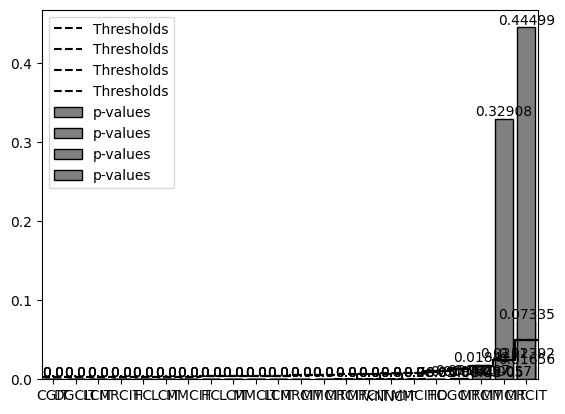

In [18]:
two_dimensional_diagram = Diagrams(
    crit_diagram_dfs,
    diagram_names=['Average', 'High KDE ratio',
                   'Low KDE ratio', 'High discr. ratio'],
    treatment_names=pivoted_df.columns[1:],
    maximize_outcome=True
)

In [19]:
two_dimensional_diagram.to_file(
    "./results/synthetic/2d_F1.pdf",
    preamble="\n".join([  # colors are defined before \begin{document}
        "\\definecolor{color1}{HTML}{84B818}",  # green
        "\\definecolor{color2}{HTML}{D18B12}",  # orange
        "\\definecolor{color3}{HTML}{1BB5B5}",  # teal
        "\\definecolor{color4}{HTML}{F85A3E}",  # red
        "\\definecolor{color5}{HTML}{4B6CFC}",  # blue
        "\\definecolor{color6}{HTML}{A347BA}",  # purple
        "\\definecolor{color7}{HTML}{FFD700}",  # gold
        "\\definecolor{color8}{HTML}{FF69B4}",  # pink
        "\\definecolor{color9}{HTML}{00CED1}",  # dark turquoise
    ]),
    axis_options={  # style the plot
        "cycle list": ",".join([  # define the markers for treatments
            "{color1,mark=*}",                     # circle
            "{color2,mark=square*}",               # square
            "{color3,mark=diamond*}",              # diamond
            "{color4,mark=triangle*}",              # triangle
            "{color5,mark=pentagon*}",             # pentagon
            "{color6,mark=otimes*}",               # circled times
            "{color7,mark=star,semithick}",        # star
            "{color8,mark=Mercedes star flipped}", # Mercedes star
            "{color9,mark=halfcircle*}",           # half circle
        ]),
        "width": "0.9*\\axisdefaultwidth",
        "height": "0.75*\\axisdefaultheight",
        "title": "Critical difference diagrams for graph F1-score"
    },
)

### Plots for SHD


#### Critical difference diagram 

In [6]:
crit_diagram_dfs = list()


pivoted_df = df.pivot_table(
    index=['n_rep', 'n_vars', 'discrete_ratio',
           'kde_ratio', 'edge_density', 'samples'],
    columns='method',
    values='SHD'
).reset_index(drop=True)
pivoted_df = pivoted_df.reset_index(drop=False)
pivoted_df[pivoted_df.isna()] = np.inf
crit_diagram_dfs.append(pivoted_df)

df_aux = df.loc[(df.discrete_ratio == '0.1') & (df.kde_ratio == '1.0'), :]
pivoted_df = df_aux.pivot_table(
    index=['n_rep', 'n_vars', 'discrete_ratio',
           'kde_ratio', 'edge_density', 'samples'],
    columns='method',
    values='SHD'
).reset_index(drop=True)
pivoted_df = pivoted_df.reset_index(drop=False)
pivoted_df[pivoted_df.isna()] = np.inf
crit_diagram_dfs.append(pivoted_df)

df_aux = df.loc[(df.discrete_ratio == '0.1') & (df.kde_ratio == '0.0'), :]
pivoted_df = df_aux.pivot_table(
    index=['n_rep', 'n_vars', 'discrete_ratio',
           'kde_ratio', 'edge_density', 'samples'],
    columns='method',
    values='SHD'
).reset_index(drop=True)
pivoted_df = pivoted_df.reset_index(drop=False)
pivoted_df[pivoted_df.isna()] = np.inf
crit_diagram_dfs.append(pivoted_df)

df_aux = df.loc[(df.discrete_ratio == '0.9'), :]
pivoted_df = df_aux.pivot_table(
    index=['n_rep', 'n_vars', 'discrete_ratio',
           'kde_ratio', 'edge_density', 'samples'],
    columns='method',
    values='SHD'
).reset_index(drop=True)
pivoted_df = pivoted_df.reset_index(drop=False)
pivoted_df[pivoted_df.isna()] = np.inf
crit_diagram_dfs.append(pivoted_df)

In [7]:
color_map = {
    '$k$NNCIT': 'tab:red',
    'MRCIT':    'tab:blue',
    'HC':       'tab:green',
    'MMCIT':    'tab:purple',
    'CGIT':     'tab:orange',
    'DGCIT':    'tab:cyan',
    'LCIT':     'tab:pink',
}
    

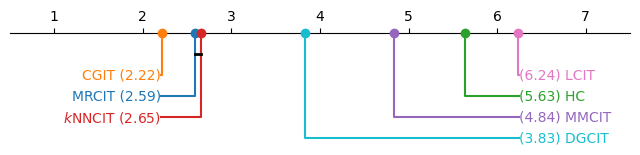

In [8]:

for i in range(4):
    rankings, statistic, p_value, critical_value, hypothesis = friedman(crit_diagram_dfs[i], alpha = 0.05, minimize=True, verbose=False)
    num_cases = pivoted_df.shape[0]
    results, _ = hommel(ranks=rankings, num_cases=num_cases, alpha=0.05, control = None, type_rank = "Friedman", verbose=False)
    plt.close()
    plt.figure(figsize=(8, 1.5), dpi=100)

    sp.critical_difference_diagram(rankings, create_symmetric_matrix(results), label_fmt_left='{label} ({rank:.3g})', label_fmt_right='({rank:.3g}) {label}', color_palette=color_map)

    plt.xlim(0.5,7.5)
    plt.savefig(f'./results/synthetic/CDD_SHD_{i+1}.eps', format='eps', bbox_inches='tight', pad_inches=0)

#### 2D critical difference diagram 

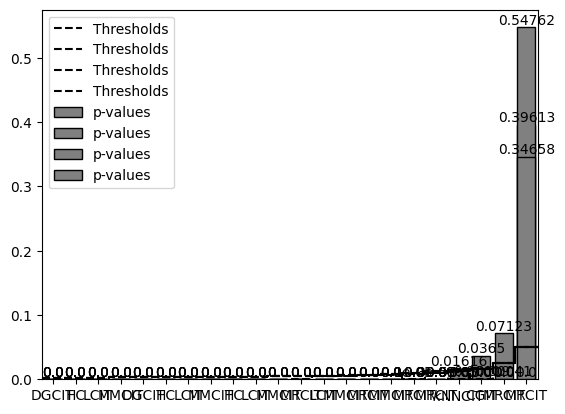

In [24]:
two_dimensional_diagram = Diagrams(
    crit_diagram_dfs,
    diagram_names=['Average', 'High KDE ratio',
                   'Low KDE ratio', 'High discr. ratio'],
    treatment_names=pivoted_df.columns[1:],
    maximize_outcome=False
)

In [25]:
two_dimensional_diagram.to_file(
    "./results/synthetic/2d_SHD.pdf",
    preamble="\n".join([  # colors are defined before \begin{document}
        "\\definecolor{color1}{HTML}{84B818}",  # green
        "\\definecolor{color2}{HTML}{D18B12}",  # orange
        "\\definecolor{color3}{HTML}{1BB5B5}",  # teal
        "\\definecolor{color4}{HTML}{F85A3E}",  # red
        "\\definecolor{color5}{HTML}{4B6CFC}",  # blue
        "\\definecolor{color6}{HTML}{A347BA}",  # purple
        "\\definecolor{color7}{HTML}{FFD700}",  # gold
        "\\definecolor{color8}{HTML}{FF69B4}",  # pink
        "\\definecolor{color9}{HTML}{00CED1}",  # dark turquoise
    ]),
    axis_options={  # style the plot
        "cycle list": ",".join([  # define the markers for treatments
            "{color1,mark=*}",                     # circle
            "{color2,mark=square*}",               # square
            "{color3,mark=diamond*}",              # diamond
            "{color4,mark=triangle*}",              # triangle
            "{color5,mark=pentagon*}",             # pentagon
            "{color6,mark=otimes*}",               # circled times
            "{color7,mark=star,semithick}",        # star
            "{color8,mark=Mercedes star flipped}", # Mercedes star
            "{color9,mark=halfcircle*}",           # half circle
        ]),
        "width": "0.9*\\axisdefaultwidth",
        "height": "0.75*\\axisdefaultheight",
        "title": "Critical difference diagrams for PDAG SHD-score"
    },
)

In [35]:
pivoted_df = df.pivot_table(
    index=['n_rep', 'n_vars', 'discrete_ratio',
           'kde_ratio', 'edge_density', 'samples'],
    columns='method',
    values='SHD'
).reset_index(drop=True)
np.isnan(pivoted_df).sum()

method
$k$NNCIT      0
CGIT          8
DGCIT         0
HC            2
LCIT        704
MMCIT         0
MRCIT         0
dtype: int64